## Notebook 4: Loading Pretrained Weights and Generating Output with GPT-2 and Gradio 🎉
## Introduction 📚

In this notebook, we take the next step in our GPT-2 journey by enhancing our custom model. Now that we have successfully built the GPT-2 architecture from scratch, it's time to bring it to life with pretrained weights, test its text generation capabilities, and add some advanced features to make it more interactive and dynamic. 

<div align="center">

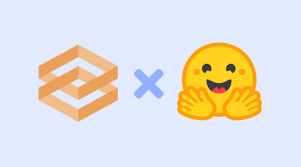
</div>


### What’s Inside?

1. **Loading Pretrained Weights with Hugging Face**: We'll use the Hugging Face `transformers` library to quickly load pretrained weights into our GPT-2 model. This will allow us to leverage the knowledge gained from large-scale training without having to start from scratch.
   
2. **Testing Model Capability**: We'll run inference using Hugging Face’s API to see what our model can generate based on a few input prompts, giving us a glimpse into its text generation abilities.

3. **Designing a Custom Inference Function**: To take things a step further, we'll implement our own inference function from scratch, adding control over key parameters like temperature and top-k sampling to influence the diversity and creativity of the generated text.

4. **Building a UI with Gradio**: Finally, we'll design a simple yet effective UI using the Gradio library to interact with the model in a seamless way. This will allow us to input text prompts and see the generated output in real-time, making the GPT-2 model easily accessible.

By the end of this notebook, you’ll have a fully functional GPT-2 model, capable of generating human-like text and equipped with a user-friendly interface for easy interaction.

Let’s dive in! 🎉

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

# Add the models path to sys.path
sys.path.append(r'C:\Users\user\Documents\SILVA AI ROADMAP\MyLLM\models')

# Import the GPTModel
from GPT.GPT import GPTModel  # Import directly from GPT

# Configuration for the GPT model
GPT_CONFIG_124 = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

# Initialize the GPT model with the configuration
model = GPTModel(GPT_CONFIG_124)

# Print the model architecture to verify
print(model)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

## 1-Loading Pretrained Weights into a Custom GPT Model

This document explains the process of loading pretrained weights from a Hugging Face GPT-2 model into a custom GPT model. Utilizing pretrained weights enhances the performance of the custom model by leveraging the knowledge acquired from a large corpus of text.

### Overview of the Process

The process involves several key steps:

1. **Importing Required Libraries**:
   - The code begins by importing necessary classes from the `transformers` library, specifically `GPT2LMHeadModel` and `GPT2Model`, which are used for language modeling and embedding representations, respectively.

2. **Loading the Pretrained GPT-2 Model**:
   - A pretrained GPT-2 model (in this case, `gpt2-small`) is loaded using `GPT2LMHeadModel.from_pretrained("gpt2")`. This model is initialized with the weights and configuration that have been trained by OpenAI.

3. **Defining Model Configurations**:
   - A dictionary, `model_names`, maps user-friendly names to the corresponding model identifiers on the Hugging Face model hub. This allows for easy access to different sizes of GPT-2 models (small, medium, large, and XL).
   - The `BASE_CONFIG` dictionary defines the basic configuration for the model, including vocabulary size, context length, dropout rate, and whether to use biases in the attention mechanisms.
   - The `model_configs` dictionary specifies model-specific configurations such as embedding dimensions, number of layers, and number of attention heads for each model size. This configuration is then updated based on the selected model size.

4. **Loading Weights from the Pretrained Model**:
   - The `load_weights` function handles the weight assignment from the Hugging Face model to the custom model. This involves checking the shape compatibility of weights and assigning them appropriately. The assignment process includes:
     - **Positional and Token Embeddings**: The weights for positional and token embeddings are assigned first, ensuring that the model can interpret the input tokens correctly.
     - **Transformer Block Weights**: The function iterates over each transformer block, assigning weights for the attention layers (query, key, value), feedforward layers, and normalization layers. Each set of weights is split as needed, and the shapes are checked for compatibility using the `assign_check` function.
     - **Final Layer Assignments**: After assigning weights for all transformer blocks, the function assigns weights for the final normalization layer and output head.

5. **Setting the Model to Evaluation Mode**:
   - The model is set to evaluation mode using `gpt_hf.eval()`, which disables layers like dropout during inference to ensure consistent outputs.

6. **Loading the Weights into a Custom Model**:
   - An instance of the custom model is created using `gpt = GPTModel(BASE_CONFIG)`, and the pretrained weights are loaded into this custom model by calling `load_weights(gpt, gpt_hf)`.

In [2]:
from transformers import GPT2LMHeadModel, GPT2Model  # Import the classes for GPT-2 models from the Hugging Face library

# Step 1: Load the pretrained GPT-2 Small model from Hugging Face
# This creates an instance of the GPT2LMHeadModel, which includes the language modeling head necessary for text generation.
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Step 2: Define a dictionary of allowed model names
# This dictionary maps user-friendly names of various GPT-2 models to their corresponding identifiers in the Hugging Face model hub.
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",          # 124 million parameters
    "gpt2-medium (355M)": "openai-community/gpt2-medium",  # 355 million parameters
    "gpt2-large (774M)": "openai-community/gpt2-large",    # 774 million parameters
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"          # 1558 million parameters
}

# Here, we specifically load the "gpt2-small" model, specifying a cache directory for storing the model weights.
gpt_hf = GPT2Model.from_pretrained(model_names['gpt2-small (124M)'], cache_dir="checkpoints")

# This disables certain layers like dropout during inference, ensuring consistent outputs during model evaluation or text generation.
gpt_hf.eval()

# Optional: If you have a custom model defined, you might want to load the pretrained weights into it
# Example (assuming `model` is your custom model):
# model.load_state_dict(pretrained_model.state_dict(), strict=False)

# Note: If using your custom model, ensure it has the same architecture as the pretrained model for proper weight loading.


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [3]:
# Define the base configuration for the model
BASE_CONFIG = {
    "vocab_size": 50257,    # The total number of unique tokens in the vocabulary
    "context_length": 1024, # The maximum number of tokens the model can process in a single input
    "drop_rate": 0.0,       # The dropout rate used during training to prevent overfitting (0.0 means no dropout)
    "qkv_bias": True        # Indicates whether to include a bias term in the query, key, and value projections
}

# Define the model-specific configurations for different sizes of GPT-2
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},   # Configuration for the small model
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16}, # Configuration for the medium model
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},  # Configuration for the large model
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},     # Configuration for the extra-large model
}

# Update the BASE_CONFIG with the settings for the selected GPT-2 model
# Here, we are selecting the configuration for the 'gpt2-small (124M)' model to update the base settings.
BASE_CONFIG.update(model_configs['gpt2-small (124M)'])

# The updated BASE_CONFIG will now include:
# - 'emb_dim': 768 (embedding dimension)
# - 'n_layers': 12 (number of transformer layers)
# - 'n_heads': 12 (number of attention heads in each layer)


In [4]:
import numpy as np
import torch

# Step 1: Define a function to assign weights and check for shape compatibility
def assign_check(left, right):
    # Check if the shapes of the two tensors are the same
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    # Clone the right tensor, detach it from the computation graph, and convert it to a nn.Parameter
    return torch.nn.Parameter(right.clone().detach())

# Step 2: Define the function to load weights from the Hugging Face model to the custom GPT model
def load_weights(gpt, gpt_hf):
    # Get the state dictionary (weights) from the Hugging Face model
    d = gpt_hf.state_dict()

    # Step 3: Assign the positional embedding weights
    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    
    # Step 4: Assign the token embedding weights
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    # Step 5: Loop through each transformer block to assign weights
    for b in range(BASE_CONFIG["n_layers"]):
        # Split the attention weights into query, key, and value weights
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        
        # Assign the query, key, and value weights for the current transformer block
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        # Split the attention biases into query, key, and value biases
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        
        # Assign the biases for the query, key, and value
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
        # Assign the output projection weights and biases for the attention layer
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        # Assign weights and biases for the feedforward layers
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        # Assign weights and biases for the layer normalization layers
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
    # Step 6: Assign weights and biases for the final normalization layer and output head
    gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
    gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
    gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])


In [5]:
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

lets run inference on an identical model from hugging face to act as a basline 

In [6]:
# Import the pipeline function from Hugging Face's transformers library
from transformers import pipeline 

# Create a text generation pipeline using the pre-trained GPT-2 model and its tokenizer
text_generator = pipeline('text-generation', model='gpt2', tokenizer='gpt2')

# Define the prompt for text generation
prompt = "Once upon a time in a distant land,"

# Generate text based on the prompt
# max_length: maximum number of tokens to generate
# num_return_sequences: number of different sequences to generate
# temperature: controls randomness in the generation process (higher means more randomness)
generated_text = text_generator(prompt, max_length=100, num_return_sequences=1, temperature=0.7)

# Print the generated text
print("Generated Text:")
# Enumerate through the generated sequences and print each one
for i, text in enumerate(generated_text):
    print(f"Generated Sequence {i + 1}: {text['generated_text']}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Text:
Generated Sequence 1: Once upon a time in a distant land, a star's brightness and brightness was affected by a light emitted from a distant star, so one can easily remember how it affected the stars. At the same time, the stars are actually moving the same direction, so it is possible that this could affect their rotation. The first observation of the Star was made when they were traveling in the Milky Way's star system, and it was discovered that the star was moving very slowly. The observation of the star's


## 3- Designing a Custom Inference Function 

In this section, we will implement the code that converts the tensor outputs of the GPT model back into text. Before diving into the code, let's briefly review how a generative model like a Large Language Model (LLM) generates text one word (or token) at a time. 

The process by which a GPT model transforms output tensors into generated text involves several key steps, as illustrated in the figure below. These steps include decoding the output tensors, selecting tokens based on a probability distribution, and converting these tokens into human-readable text.

<div align="center">

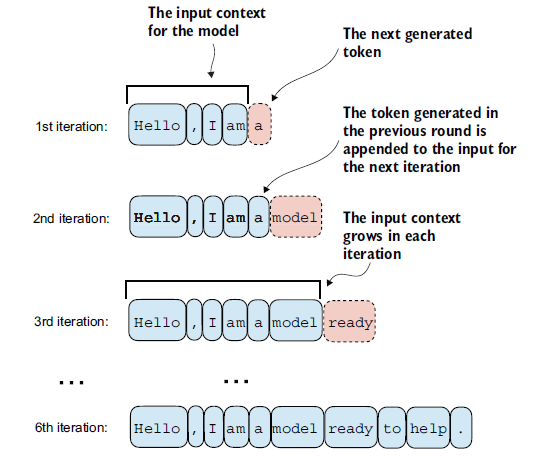

</div>

### A Simple Text Generation Pipeline

A basic text generation pipeline consists of the following steps:

1. **Tokenizing the Input**: The first step is to tokenize the input text, breaking it down into smaller components (tokens) that the model can understand. Tokenization converts words or phrases into numerical representations based on the model's vocabulary.

2. **Feeding Data to the Model**: Next, we feed the tokenized input to the model, which then performs inference. The model generates a distribution of probabilities over its vocabulary, which is represented as the softmax output.

3. **Extracting Logits for Generation**: The output of the model includes logits in the shape of `(batch_size, n_token, vocab_size)`. For text generation, we focus specifically on the logits corresponding to `n_token`, as these will be used to determine the next token in the generated sequence.

By following these steps, we can convert the model's output into coherent text, enabling the generation of meaningful sentences and paragraphs.


In [35]:
def generate_text_simple(model, prompt, max_new_tokens, context_size, tokenizer):
    # Step 1: Encode the input prompt into token indices
    idx = tokenizer.encode(prompt)  # Convert the prompt into a list of token indices
    idx = torch.tensor(idx, dtype=torch.long).unsqueeze(0)  # Convert to a tensor and add batch dimension

    # Step 2: Generate new tokens one at a time
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Get the most recent context of tokens (up to context_size)
        
        with torch.no_grad():  # Disable gradient calculation for inference
            logits = model(idx_cond)  # Forward pass through the model to get logits
            logits = logits[:, -1, :]  # Take the logits of the last token generated
            
            # Step 3: Calculate probabilities and sample the next token
            probas = torch.softmax(logits, dim=-1)  # Apply softmax to convert logits to probabilities
            idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # Get the index of the token with the highest probability
            
            # Step 4: Concatenate the new token to the existing sequence
            idx = torch.cat((idx, idx_next), dim=1)  # Append the newly generated token to the sequence
            
            # Step 5: Decode the token indices back to a string
            result = tokenizer.decode(idx.squeeze(0).tolist())  # Convert the indices back to text
            
    return result  # Return the generated text


import tiktoken  # Import tiktoken for tokenization

# Step 6: Initialize the tokenizer for the GPT-2 model
tokenizer = tiktoken.get_encoding('gpt2')

# Define the prompt for text generation
prompt = "Once upon a time in a distant land,"

# Step 7: Generate text using the model
generated_text = generate_text_simple(
    model=gpt,  # Use the custom GPT model
    prompt=prompt,  # Input prompt for text generation
    max_new_tokens=30,  # Maximum number of new tokens to generate
    context_size=GPT_CONFIG_124["context_length"],  # Context size defined in the model configuration
    tokenizer=tokenizer  # Tokenizer for encoding and decoding
)

# Step 8: Print the generated text
print("Generated text: ")
print(f"Generated Sequence: {generated_text}")  # Display the generated text


Generated text: 
Generated Sequence: Once upon a time in a distant land, the sun was shining, and the moon was shining. The sun was shining, and the moon was shining. The sun was shining, and the moon


## Decoding strategies to control randomness
Certainly! Let’s break down the issues with the generated text and enhance your explanation about decoding strategies to control randomness in text generation.

---

### Decoding Strategies to Control Randomness

Upon analyzing the generated text, we notice several shortcomings that affect the overall quality and diversity of the output:

1. **Repetition of Phrases**:
   - The model tends to repeat phrases like "the sun was shining," especially as the sequence length increases. This repetitiveness can make the generated text feel mechanical and unengaging. 

2. **Stagnant Output**:
   - Even when we regenerate text with the same prompt, we often observe the same or very similar outputs. This indicates a lack of variability in the generation process, which should ideally leverage the model's learned probabilities to produce diverse sequences.

3. **Sequence Breakdown**:
   - As the sequence becomes longer, it appears that the model struggles to maintain coherence and context, leading to fragmented or nonsensical phrases. This is often a result of the model relying too heavily on earlier tokens without effectively incorporating the entire context.

### What Went Wrong?

The issues outlined can be attributed to the following factors:

1. **Decoding Methodology**:
   - The method of choosing the next token significantly impacts the generated text. Using **greedy sampling** (selecting the token with the highest probability) can lead to deterministic and repetitive outputs. Instead, we should consider probabilistic approaches like **temperature sampling** and **top-k sampling**.

2. **Lack of Diversity**:
   - If the output does not vary with different generations, it suggests that the sampling method may not be exploring the probability distribution effectively. This can be exacerbated by settings that don't allow enough randomness, such as high temperature values or low top-k values.


### Enhancing the Model's Output

To address these issues and improve the text generation, we can employ a combination of advanced decoding strategies:

1. **Adjusting Temperature**:
   - Implement temperature scaling to control randomness. A lower temperature (e.g., 0.7) makes the output more focused, while a higher temperature (e.g., 1.2) introduces more variability. This allows the model to sample from less likely tokens, reducing repetition and increasing diversity.

2. **Utilizing Top-k Sampling**:
   - Top-k sampling helps focus on the most probable tokens while excluding less likely ones. By adjusting the value of k, we can control how many options the model considers, promoting more varied outputs.


## Understanding Temperature and Top-k Sampling
Temperature:

The temperature parameter controls the randomness of predictions by scaling the logits before applying the softmax function. A higher temperature (e.g., >1) results in more randomness (more diverse outputs), while a lower temperature (e.g., <1) makes the model more confident and conservative in its predictions.

<div align="center">

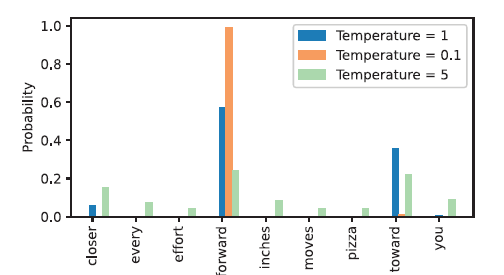

</div>





In [ ]:
# lets explore the comcept of temperature in code form : 

# Function to apply temperature scaling to the model's output logits
def apply_temperature(logits, temperature):
    """
    Applies temperature scaling to the logits.

    Parameters:
    - logits (torch.Tensor): The raw output from the model before applying softmax.
    - temperature (float): A scaling factor that controls the randomness of the output.

    Returns:
    - torch.Tensor: The probabilities obtained by applying softmax after temperature scaling.
    """

    # Check if the temperature is 1.0 (no scaling)
    if temperature == 1.0:
        # When temperature is 1.0, we simply apply softmax to convert logits to probabilities
        # This gives us the original probabilities based on the model's output
        return torch.tensor(F.softmax(logits, dim=-1))  # Softmax applied directly to logits
    
    else:
        # When temperature is different from 1.0, we scale the logits by the temperature factor
        # A lower temperature (e.g., < 1) makes the distribution sharper (higher confidence in top predictions)
        # A higher temperature (e.g., > 1) makes the distribution flatter (increases randomness)
        scaled_logits = logits / temperature  # Scale the logits by the temperature
        return torch.tensor(F.softmax(scaled_logits, dim=-1))  # Apply softmax to the scaled logits


Top-k Sampling:

This method limits the number of possible next tokens to the top-k highest probability tokens. By sampling from only these top-k tokens, you reduce the chances of selecting low-probability, nonsensical tokens while still maintaining some variability.

<div align="center">

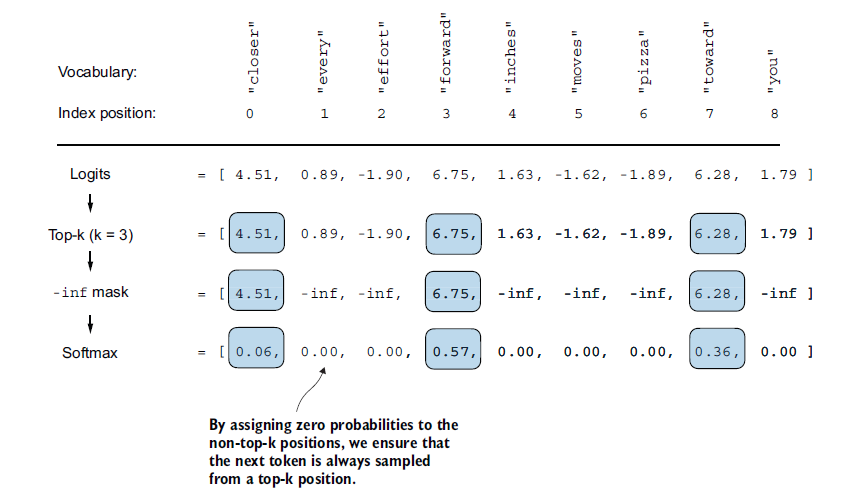

</div>


In [11]:
# Function to filter logits to keep only the top k
def top_k_logits(logits, k):
    """
    Filter the logits to keep only the top k values.
    """
    # Get the threshold for the k-th largest logit
    top_k_values, _ = torch.topk(logits, k)
    
    # Get the minimum value among the top k values (this will be the threshold)
    threshold = top_k_values[-1]  # Since top_k_values is 1D, we can directly index it

    # Create a mask for values to remove
    indices_to_remove = logits < threshold

    # Set low probabilities to -inf
    logits[indices_to_remove] = float('-inf')  
    return logits

In [12]:
# Mock logits data: Simulating model output for 10 tokens
mock_logits = torch.tensor([2.0, 1.0, 0.1, 0.5, 1.5, 3.0, 2.5, 0.2, 0.8, 1.8])

# Example usage
temperature = 0.5  # Adjust this value to see the effect
k = 5  # Number of top logits to keep

# Apply temperature scaling to mock logits
scaled_logits = apply_temperature(mock_logits, temperature)
print("Scaled logits with temperature:")
print(scaled_logits)

# Apply top-k filtering to the original logits
top_k_filtered_logits = top_k_logits(mock_logits.clone(), k)  # Use clone to avoid modifying original logits
print("\nTop-k filtered logits:")
print(top_k_filtered_logits)

# Apply softmax to top-k filtered logits for probabilities
top_k_probs = F.softmax(top_k_filtered_logits, dim=-1)
print("\nProbabilities after top-k filtering:")
print(top_k_probs)


Scaled logits with temperature:
tensor([0.0802, 0.0109, 0.0018, 0.0040, 0.0295, 0.5925, 0.2180, 0.0022, 0.0073,
        0.0537])

Top-k filtered logits:
tensor([2.0000,   -inf,   -inf,   -inf, 1.5000, 3.0000, 2.5000,   -inf,   -inf,
        1.8000])

Probabilities after top-k filtering:
tensor([0.1472, 0.0000, 0.0000, 0.0000, 0.0893, 0.4002, 0.2427, 0.0000, 0.0000,
        0.1205])


Now lets re-implement the generation function but now with the addition of temperature and top-k sampling.

In [63]:

import tiktoken  # Import tiktoken for tokenization
tokenizer = tiktoken.get_encoding('gpt2')

def generate(model, prompt, max_new_tokens, context_size, tokenizer, temperature=0.0, top_k=None, eos=None):
    # Step 1: Encode the input prompt into token indices
    idx = tokenizer.encode(prompt)  # Convert the prompt into a list of token indices
    idx = torch.tensor(idx, dtype=torch.long).unsqueeze(0)  # Convert to a tensor and add batch dimension

    # Initialize idx_gen to store generated token indices
    idx_gen = idx.clone()  # Start with the prompt indices

    # Step 2: Generate new tokens one at a time
    for _ in range(max_new_tokens):
        idx_cond = idx_gen[:, -context_size:]  # Get the most recent context of tokens (up to context_size)
        
        with torch.no_grad():  # Disable gradient calculation for inference
            logits = model(idx_cond)  # Forward pass through the model to get logits
            logits = logits[:, -1, :]  # Take the logits of the last token generated
            
            if top_k is not None:
                # Step 3: Filter logits to keep only the top k values
                top_k_values, _ = torch.topk(logits, k=top_k)  
                min_value = top_k_values[:, -1].unsqueeze(1)  # Get the minimum value of the top k logits
                logits = torch.where(logits < min_value, torch.tensor(float('-inf')).to(logits.device), logits)
            
            # Step 4: Apply temperature scaling to logits
            if temperature > 0.0:
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
                idx_next = torch.multinomial(probs, num_samples=1)  # Sample from the distribution
            else: 
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Take the index of the max logit
            
            # Step 5: Check for end of sequence (EOS)
            if eos is not None and torch.equal(idx_next, torch.tensor(eos).to(logits.device)):
                break
            
            # Step 6: Append the new token to the generated sequence
            idx_gen = torch.cat((idx_gen, idx_next), dim=1)
    
    # Decode the generated token indices back to text
    result = tokenizer.decode(idx_gen.squeeze(0).tolist())  # Convert the indices back to text 
    return result  # Return the generated text


In [64]:
torch.manual_seed(123)
token_ids = generate(
model=gpt,
prompt="Once upon a time in a distant land,",
max_new_tokens=30,
context_size=GPT_CONFIG_124["context_length"],
tokenizer=tokenizer,
temperature=1.4,
top_k=25
)
print("Output text:\n",token_ids )

Output text:
 Once upon a time in a distant land, the world will fall for you, I am certain of it" – and there has ever been a tale written to explain the true nature of death:


Notice the Difference: It's Quite Obvious!
Generated Text:
Once upon a time in a distant land, the sun was shining, and the moon was shining. The sun was shining, and the moon was shining. The sun was shining, and the moon...

Output Text:
Once upon a time in a distant land, the world will fall for you, I am certain of it — and there has ever been a tale written to explain the true nature of death:

At first glance, the initial generated output might lead you to believe that a larger model or a more extensive training set is needed. However, the improvement in the second output is primarily due to better control of randomness through techniques like temperature scaling and top-k filtering. These adjustments can significantly enhance the quality of generated text without requiring more resources.

## 4. **Building a UI with Gradio**:

# The Importance of Presenting Machine Learning Models via UI

In today's rapidly advancing technological landscape, machine learning (ML) models are becoming integral to various industries, from healthcare to entertainment. However, the complexity of these models often poses a challenge for consumers and non-technical users. Presenting these models through a user-friendly interface (UI) is essential for several reasons:

## Utilizing Gradio for User-Friendly Interfaces

To effectively present our ML models to consumers and non-technical users, we utilize **Gradio**. This open-source library enables us to create simple and interactive web-based UIs for our models with minimal coding. With Gradio, we can:

- Quickly develop and deploy user-friendly interfaces that allow users to interact with our models seamlessly.
- Provide a platform where users can input data, view outputs, and understand the model's functionalities without needing technical expertise.
- Foster engagement and gather feedback efficiently, which helps us refine our models continuously.

In conclusion, presenting machine learning models through intuitive UIs is vital for enhancing accessibility, promoting engagement, and building trust among consumers and non-technical users. By leveraging tools like Gradio, we can make our models more approachable and effective, ensuring they meet the needs of a wider audience.

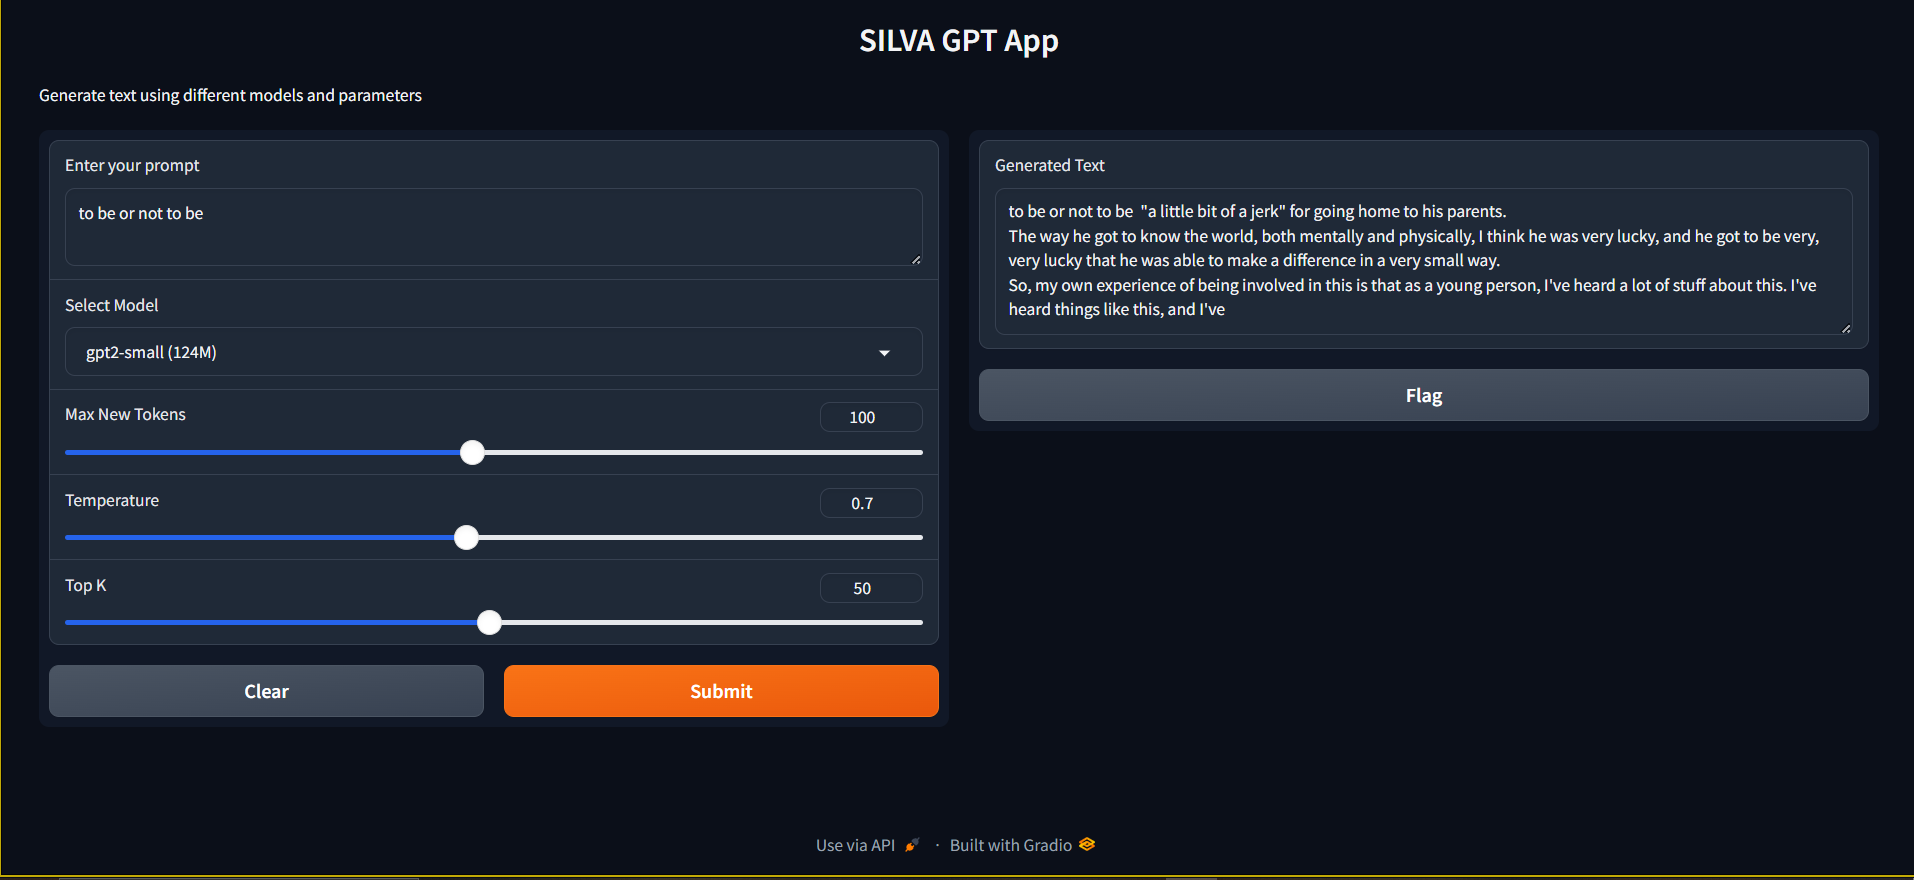

In [68]:
def generate_text_ui(prompt, max_length, temperature, top_k):
    # Load the GPT-2 tokenizer for encoding the input prompt
    tokenizer = tiktoken.get_encoding('gpt2')

    # Generate text using the existing 'generate' function
    generated_text = generate(
        model=gpt,  # Pass the loaded model for text generation
        prompt=prompt,  # Input prompt from the user
        max_new_tokens=max_length,  # Maximum number of tokens to generate
        context_size=GPT_CONFIG_124["context_length"],  # Context size from the GPT configuration
        tokenizer=tokenizer,  # Tokenizer for encoding/decoding text
        temperature=temperature,  # Temperature for controlling randomness in generation
        top_k=top_k  # Top-k filtering for sampling
    )
    
    # Return the generated text to be displayed in the UI
    return generated_text


In [69]:
import gradio as gr 

# Create Gradio Interface
def interface():
    # Define the Gradio Interface
    gr.Interface(
        fn=generate_text_ui,  # Function to call when generating text
        inputs=[  # Define the input components
            gr.Textbox(lines=2, label="Enter your prompt"),  # Textbox for user prompt input
            gr.Slider(10, 200, step=1, value=100, label="Max New Tokens"),  # Slider for max new tokens
            gr.Slider(0.0, 1.5, step=0.1, value=0.7, label="Temperature"),  # Slider for sampling temperature
            gr.Slider(1, 100, step=1, value=50, label="Top K")  # Slider for top K filtering
        ], 
        outputs=gr.Textbox(label="Generated Text"),  # Textbox to display generated text
        title="SILVA GPT App",  # Title of the app
        description="Generate text using different models and parameters",  # Brief description
        theme="default"  # Default theme for the interface
    ).launch(share=True)  # Launch the interface with sharing enabled



In [71]:
# Call the interface function to display the Gradio UI

interface()

Running on local URL:  http://127.0.0.1:7870

Could not create share link. Missing file: c:\Users\user\anaconda3\envs\torch\lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\Users\user\anaconda3\envs\torch\lib\site-packages\gradio


# Summary of Notebook Activities

In this notebook, we focused on building a text generation application using a custom implementation of GPT-2. Here’s a breakdown of the steps we followed:

1. **Loading Pre-trained Weights**: We utilized the Hugging Face library to load the pre-trained weights of the GPT-2 model, ensuring that all configurations matched our model  setup (which we build from scratch in the previous notebook)for seamless integration.

2. **Custom Generation Function**: Instead of relying on the Hugging Face pipeline for text generation, we implemented a custom generation function from scratch. This approach enhanced our understanding of the underlying mechanisms of text generation.

3. **Enhanced Text Generation**: We improved the text generation process by adding temperature scaling and top-k sampling techniques. These enhancements resulted in noticeable improvements in the quality and diversity of the generated text.

4. **Gradio UI Integration**: We built a user-friendly interface using Gradio, allowing users to easily input prompts and adjust generation parameters. This seamless integration facilitated real-time interaction with our text generation model.

This notebook serves as a practical demonstration of loading pre-trained models, implementing custom text generation logic, and creating an interactive user interface.


# 🎉 Congratulations, You Rockstar! 

You've just unleashed your very own text generation model using GPT-2, complete with awesome enhancements like temperature scaling and top-k sampling. You even built a snazzy Gradio interface for seamless interaction—talk about leveling up your AI game! 🚀

## 🌟 What’s Next?

Get ready for the next adventure! In the upcoming notebook, we're bringing out the heavy artillery as we gear up to train GPT-2 from scratch across multiple GPUs! 💪🔧 Even if we don't have those fancy machines just yet, we’ll write the script anyway—because who needs hardware when you've got skills, right? 

Stay tuned for a wild ride into the world of model training! Let’s make some magic happen! ✨


In [76]:
import gradio as gr
import random

# Fun function to generate clever deep learning jokes and motivational messages
def deep_humor():
    jokes = [
        "🤖 Why did the neuron break up with the dataset? It couldn’t find enough connection! 🧠",
        "📉 My loss function and I are like soulmates—we keep getting closer but never quite hit zero. 💔",
        "🏋️‍♂️ I’m not saying my model’s heavy, but even my GPU’s asking for a cheat day! 🏋️‍♀️",
        "🚀 Why did the deep learning model go to space? To reduce its overfitting by adding more space data! 🌌",
        "💥 My code doesn’t always work, but when it does, it does so on the last line before the crash! 💻",
        "🌐 Neural nets are like relationships—they take forever to train and sometimes, they still don’t generalize. 😂",
        "🔥 Remember, friends don't let friends use ReLU without any leaky alternatives! ⚡"
    ]
    next_adventure = "⚔️ Next up: We’re taking GPT-2 into the big leagues—training from scratch on multiple GPUs. (Don’t worry, we’ll write the script even if our GPUs are imaginary for now!) 💥"
    return random.choice(jokes), next_adventure

# Create a Gradio interface to celebrate with DL-themed jokes
def celebration_interface():
    gr.Interface(
        fn=deep_humor, 
        inputs=[], 
        outputs=[
            gr.Textbox(label="Clever AI Joke", lines=2),
            gr.Textbox(label="What’s Next?", lines=2)
        ],
        title="🎉 Deep Humor",
        description="Congratulations on taming GPT-2! Now enjoy some deep learning humor, and get ready for the next epic challenge!",
        theme="default",
        live=True
    ).launch(share=False)

# Launch the celebration interface
celebration_interface()


Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.
